<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/ESAA_0620_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-1 ESAA 5기 김혜준 실습 필사 - 0620(월) 16주차 과제

## [Baseline]2. 전이학습(transfer learning)을 통한 이미지 분류

In [1]:
#필요한 library 들을 load 합니다.
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import random
import numpy as np
from tqdm import tqdm

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from multiprocessing import cpu_count
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import CrossEntropyLoss
from torchvision.models import efficientnet_b3 as efficientnet
from sklearn.model_selection import train_test_split

### 데이터 load, 전처리

기본적인 전처리 코드

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    transforms.Resize([224,224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #픽셀 단위 데이터를 정규화 시켜줍니다.
])

데이터 로드

* DACON 데이터를 다운받을 수 없으므로 torchvision에서 바로 CIFAR10 데이터 로드

In [3]:
import torchvision

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


* Pytorch의 ImageFolder 메소드를 사용하여 folder의 이름을 자동으로 라벨링하는 과정은 생략

In [ ]:
# train_data = datasets.ImageFolder(root='./data/train/',transform=transform)

train 데이터에서 validation 데이터 분리

In [4]:
train_idx, valid_idx = train_test_split(np.arange(len(train_data)), test_size=0.2, 
                                        random_state=42, shuffle=True, stratify=train_data.targets)

batch_size 설정

* batch_size : 하드웨어에 한번에 load할 데이터의 크기
* num_workers : 데이터 로드 멀티 프로세싱을 위한 파라미터

In [5]:
batch_size = 32
num_workers = int(cpu_count() / 2)

data loader 생성

* data loader : 데이터 셋을 순회하며 모델에 데이터를 넣어주는 객체

In [6]:
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(train_idx), num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(valid_idx), num_workers=num_workers)

데이터 크기 확인

In [7]:
train_total = len(train_idx)
valid_total = len(valid_idx)

train_batches = len(train_loader)
valid_batches = len(valid_loader)

In [8]:
print('total train imgs :',train_total,'/ total train batches :', train_batches)
print('total valid imgs :',valid_total, '/ total valid batches :', valid_batches)

total train imgs : 40000 / total train batches : 1250
total valid imgs : 10000 / total valid batches : 313


### Device 설정

* gpu 존재 가정

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

### 모델 불러오기 / 파라미터 설정

전이학습을 위한 모델 load

* Pytorch의 `models` 메소드 사용하여 외부 모델 불러오기
  - efficientnet_b3 모델 사용
    - `pretrained = True` : ImageNet이라는 데이터셋을 대상으로 학습된 모델이 load
    - `pretrained = False` : 모델의 구조만 load되고 모델의 가중치들은 load 되지 않음

In [10]:
net = models.efficientnet_b3(pretrained=False) # 사전 학습 모델 가중치 사용 안함
net.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

모델에 데이터를 학습하기 위해 마지막 layer의 output size와 분류할 라벨 수 입력

In [11]:
net.fc = nn.Linear(1000, 10)
net = net.to(device) 

모델 파라미터 설정

In [12]:
criterion = CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
epochs = 10

### 학습

반복문을 이용해 학습 진행

In [13]:
for epoch in range(epochs):
    net.train()
    
    train_loss = 0 
    train_correct = 0
    tqdm_dataset = tqdm(train_loader)
    for x,y in tqdm_dataset:
        x = x.to(device)
        y = y.to(device)
        outputs = net(x)
        loss = criterion(outputs,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(loss.item()),
        })

    train_loss = train_loss / train_batches
    train_acc = train_correct / train_total
    
    net.eval()
    
    valid_loss = 0 
    valid_correct = 0
    tqdm_dataset = tqdm(valid_loader)
    with torch.no_grad():
        for x,y in tqdm_dataset:
            x = x.to(device)
            y = y.to(device)
            
            outputs = net(x)
            loss = criterion(outputs, y)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_correct += predicted.eq(y).sum().item()
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(loss.item()),
            })
            
    valid_loss = valid_loss / valid_batches
    valid_acc = valid_correct / valid_total
        
    print('epochs',epoch+1, 'train loss',train_loss,'train acc', train_acc, 'valid loss',valid_loss, 'valid acc',valid_acc)

100%|██████████| 313/313 [00:28<00:00, 10.87it/s, Epoch=1, Loss=1.551943]


epochs 1 train loss 1.6966753512859345 train acc 0.376775 valid loss 1.296245432509401 valid acc 0.5296


100%|██████████| 313/313 [00:30<00:00, 10.35it/s, Epoch=2, Loss=1.212281]


epochs 2 train loss 1.1056740527153015 train acc 0.6058 valid loss 0.9758976576046441 valid acc 0.6471


100%|██████████| 313/313 [00:28<00:00, 10.82it/s, Epoch=3, Loss=0.590946]


epochs 3 train loss 0.8361450515270233 train acc 0.71125 valid loss 0.6625642281846879 valid acc 0.7726


100%|██████████| 313/313 [00:33<00:00,  9.28it/s, Epoch=4, Loss=0.575421]


epochs 4 train loss 0.6727955669164658 train acc 0.7684 valid loss 0.5981647015665286 valid acc 0.7948


100%|██████████| 313/313 [00:29<00:00, 10.51it/s, Epoch=5, Loss=0.243548]


epochs 5 train loss 0.5620462012290954 train acc 0.807475 valid loss 0.5465965263854963 valid acc 0.815


100%|██████████| 313/313 [00:28<00:00, 10.84it/s, Epoch=6, Loss=0.659955]


epochs 6 train loss 0.4784223057508469 train acc 0.835375 valid loss 0.4735041603017539 valid acc 0.8382


100%|██████████| 313/313 [00:29<00:00, 10.65it/s, Epoch=7, Loss=0.958605]


epochs 7 train loss 0.42211734132170675 train acc 0.85605 valid loss 0.46215200447998106 valid acc 0.8399


100%|██████████| 313/313 [00:28<00:00, 10.89it/s, Epoch=8, Loss=0.348217]


epochs 8 train loss 0.37077673984467985 train acc 0.87205 valid loss 0.4321642439491071 valid acc 0.8542


100%|██████████| 313/313 [00:29<00:00, 10.58it/s, Epoch=9, Loss=0.519880]


epochs 9 train loss 0.32027234759628775 train acc 0.88885 valid loss 0.4324488537475324 valid acc 0.8566


100%|██████████| 313/313 [00:28<00:00, 10.84it/s, Epoch=10, Loss=0.253583]

epochs 10 train loss 0.2800130642324686 train acc 0.9027 valid loss 0.4370574519371453 valid acc 0.8554


### 모델 저장 / 불러오기

학습된 모델의 가중치 저장

In [14]:
path = './model.pth'
torch.save(net.state_dict(),path)

저장된 모델 불러오기

In [15]:
path = './model.pth'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

### 추론

test 데이터 불러오기

In [16]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + "test/*.jpg")):
    an_img = PIL.Image.open(filename) 
    img_array = np.array(an_img) 
    test_images.append(img_array) 

test_images = np.array(test_images)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(self.img_list[idx]), self.img_labels[idx]

In [18]:
test_set = CustomDataset(transform)

In [19]:
test_loader = DataLoader(test_set, batch_size = batch_size, num_workers=num_workers)

test 데이터 예측

* 학습이 진행되지 않도록 net.eval() 코드 작성 : 데이터가 back propagation 되어 가중치가 수정되지 않도록 함

* 현재 sample_submission.csv 파일을 다운로드할 수 없어 아래 코드 실행은 생략

In [ ]:
import pandas as pd
sample_submission = pd.read_csv('./data/sample_submission.csv')

net.eval()

batch_index = 0

for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    outputs = net(images)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

라벨 복원

* 예측된 데이터의 라벨이 숫자로 되어 있기 때문에 라벨 복원 필요

In [ ]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.to_csv('submit.csv',index=False)

## <파이썬 딥러닝 텐서플로>
## PART 04  합성곱 신경망(CNN)

### 04 위성 이미지 분류

#### 4-1 텐서플로 데이터셋 로드
* EuroSAT : 인공위성에서 지표면을 촬영한 이미지와 토지이용분류(Land Use and Land Coder) 값이 정리되어 있는 데이터셋
  - 총 27000장의 위성 사진과 10개의 토지이용분류 값이 매칭되어 제공

라이브러리 불러오기

In [21]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

EuroSAT 데이터셋 불러오기

* `load` 함수 사용
  - URL을 통해 데이터 다운로드
  - `with_info` : 메타 정보 포함 여부 지정
    - `with_info=True` : '(훈련 셋, 검증 셋), 메타 정보' 순으로 정리되어 반환
    - `with_info=False` : '(훈련 셋, 검증 셋)' 형태의 튜플로 반환
  - `data_dir` : 다운로드한 데이터셋 파일 저장 위치 지정
  - train 데이터만 제공
  
    -> 80%는 훈련 셋(train_ds), 20%는 검증 셋(valid_ds)로 분할하여 저장

In [22]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = "dataset/"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True, # 메타 정보
                                        data_dir=DATA_DIR) # 파일 저장 위치 지정
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteIU3773/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


> 이미지는 (64, 64, 3) 형태

In [23]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

> * `info` : 메타 정보 할당받은 변수 -> 데이터셋에 대한 기본 정보
> * EuroSAT 데이터셋의 2가지 유형 중 JPEG 이미지로 인코딩한 RGB 데이터셋('eurosat/rgb')을 다운로드

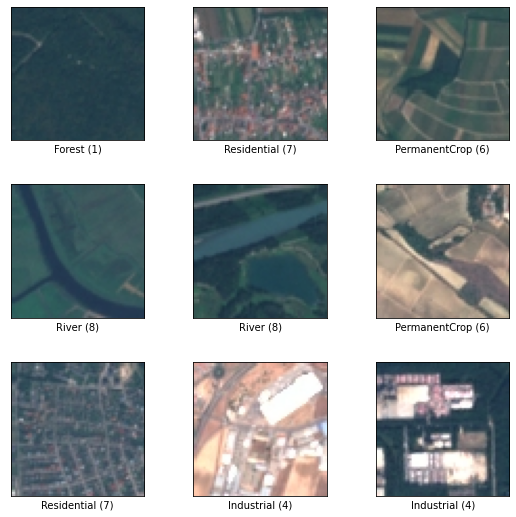

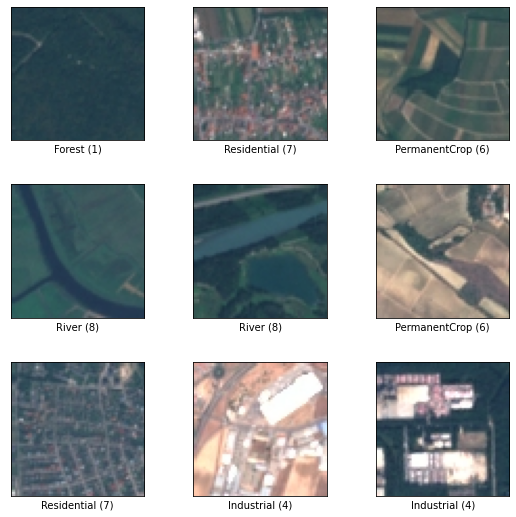

In [24]:
# 데이터 확인
tfds.show_examples(train_ds, info) # 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

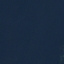
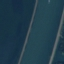
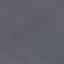
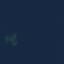
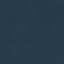
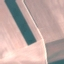
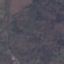
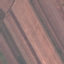
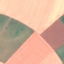
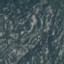

In [25]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info) # 샘플 이미지 10개를 화면에 표시

> 클래스 0 : 경작지(AnnualCrop)
>
> 클래스 9 : 바다/호수(SeaLake)

In [26]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


> 토지이용분류에 해당하는 정답 클래스는 10개

In [27]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
# 메타 데이터의 features 값 중 label에 해당하는 메타 정보에 int2str() 메소드 적용
print(info.features["label"].int2str(6))

PermanentCrop


> 클래스 6 : 영구 작물(PermanentCrop)

#### 4-2 데이터 전처리

* 텐서플로 데이터셋 사용 시 장점
  - 딥러닝 학습에 필요한 데이터셋을 쉽게 구할 수 있음
  - 데이터 전처리 과정이 매우 쉬움 : 필요한 함수들을 제공, 텐서 연산을 효율적으로 처리할 수 있는 최적화 지원

데이터 전처리

1. 데이터 전처리 함수 preprocess_data 정의
  - 텐서플로 연산은 float32 숫자 값을 사용 -> `cast` 함수로 자료형을 float32로 변환
  - 입력 이미지는 0~255 사이의 픽셀 값 -> 255로 나눠서 정규화

2. `map` 함수를 이용해 사용자 정의 함수 매핑하여 텐서플로 데이터셋에 적용
  - `num_parallel_calls` 옵션을 AUTOTUNE으로 지정하여 텐서플로 병렬연산 처리 자동 최적화
    - 오토튠 미적용 시 데이터를 읽어서 매핑하고 훈련하는 과정을 순차적으로 처리하기 때문에 시간이 오래 걸림    
    
    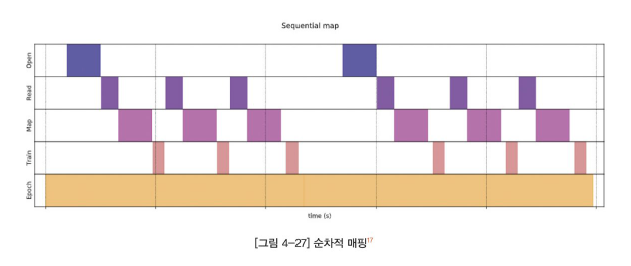
    - 오토튠 적용 시 하드웨어 리소스를 병렬로 매핑하여 처리하기 때문에 같은 작업을 훨씬 짧은 시간에 처리 가능

    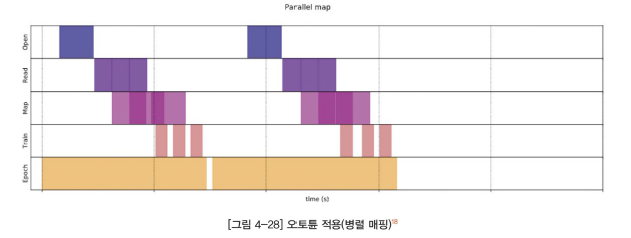


3. 정규화 변환을 마친 데이터셋에 `shuffle()` 메소드 적용하여 순서 랜덤하게 섞기
  - 모델의 일반화된 성능 향상 위해 모델의 가중치를 학습하는데 사용되는 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 무작위성 부여
    - `buffer_size` 파라미터
      - 데이터셋의 크기가 작은 경우 전체 데이터셋의 개수만큼 지정해주는 것이 무작위성을 확보하는 데 유리
      - 데이터셋 개수가 많거나 이미지 파일의 크기가 커서 시스템상의 메모리에 전부 올릴 수 없는 경우 1000으로 지정
  - 처음 1000개의 데이터를 가져와서 섞고, 그 중 64개의 데이터를 랜덤하게 선택해서 하나의 배치 구성
  - 평가 목적에 활용되는 검증 데이터셋은 순서가 큰 의미가 없기 때문에 `shuffle()` 함수 사용할 필요 없음

4. `prefetch()` 메소드를 이용해 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템을 조율
  - 병렬 처리를 통해 모델 훈련 시간 단축

In [28]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

#### 4-3 모델 훈련 및 검증

Sequential API로 딥러닝 모델 생성

In [29]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        # 유닛 1
        tf.keras.layers.BatchNormalization(), # 배치 정규화
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'), # 합성곱
        tf.keras.layers.MaxPooling2D((2, 2)), # 풀링
        # 유닛 2
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        # Dense 레이어와 Dropout으로 구성된 최종 분류기
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

모델 컴파일 및 훈련

In [30]:
# 모델 컴파일
# 예측 클래스가 10개인 다중 분류 문제에 적합한 손실함수와 평가지표 설정
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 23s 29ms/step - loss: 1.6053 - accuracy: 0.4450 - val_loss: 1.5744 - val_accuracy: 0.4811
Epoch 2/50
338/338 [==============================] - 9s 26ms/step - loss: 1.1862 - accuracy: 0.5872 - val_loss: 0.8439 - val_accuracy: 0.7287
Epoch 3/50
338/338 [==============================] - 9s 27ms/step - loss: 0.9934 - accuracy: 0.6550 - val_loss: 0.7311 - val_accuracy: 0.7613
Epoch 4/50
338/338 [==============================] - 10s 29ms/step - loss: 0.8779 - accuracy: 0.6950 - val_loss: 0.6859 - val_accuracy: 0.7839
Epoch 5/50
338/338 [==============================] - 10s 29ms/step - loss: 0.7901 - accuracy: 0.7326 - val_loss: 0.7303 - val_accuracy: 0.7563
Epoch 6/50
338/338 [==============================] - 10s 27ms/step - loss: 0.7126 - accuracy: 0.7550 - val_loss: 0.5897 - val_accuracy: 0.7909
Epoch 7/50
338/338 [==============================] - 7s 20ms/step - loss: 0.6394 - accuracy: 0.7862 - val_loss: 0.5089 - val_accuracy: 0.

In [31]:
# # 손실함수, 정확도 그래프 그리는 함수 정의
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

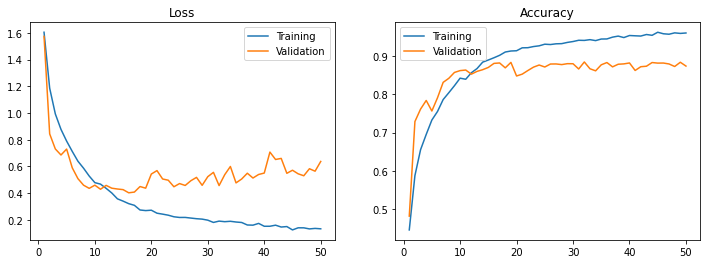

In [32]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 50)

> 10 epoch까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격하게 감소
>
> 그 이후로는 검증 셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합되는 경향 나타남

#### 4-4 데이터 증강(Data Augmentation)

* 데이터 증강 : 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식, 모델이 새로운 데이터에 대한 예측력을 강화하도록 함
  - 이미지 분류 문제에서 과대적합 해소
  - 모델의 일반화된 Robust한 성능을 확보

EuroSAT 데이터셋 샘플 이미지 시각화

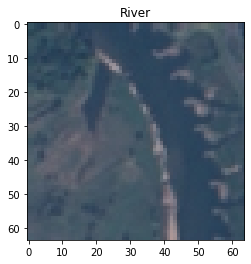

In [41]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

샘플 이미지에 변화를 주기 전과 후를 비교하는 시각화 함수 정의

In [42]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

다양한 데이터 증강 기법 적용

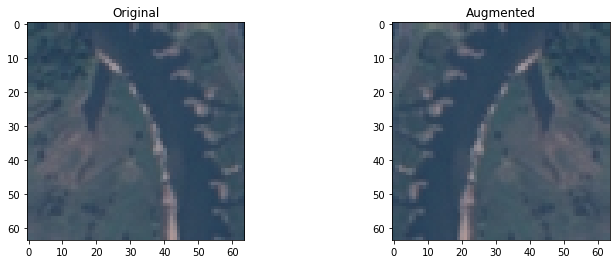

In [43]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

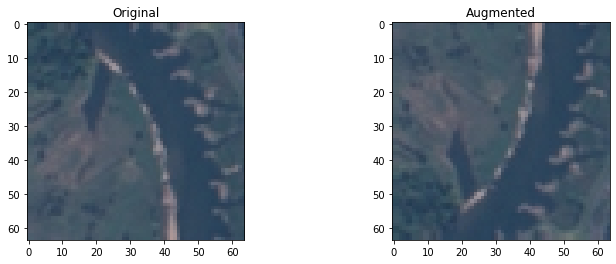

In [44]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

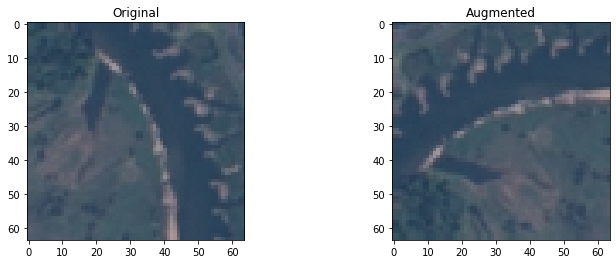

In [45]:
# 회전 
rotate90 = tf.image.rot90(image) # 이미지를 반시계 방향으로 90도 회전
plot_augmentation(image, rotate90)

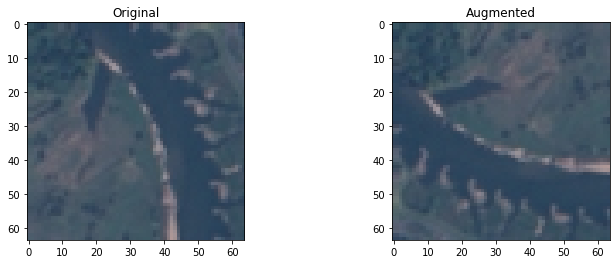

In [46]:
# transpose 
transpose = tf.image.transpose(image) # 이미지 텐서 행렬의 행과 열 위치 바꿔줌
plot_augmentation(image, transpose)

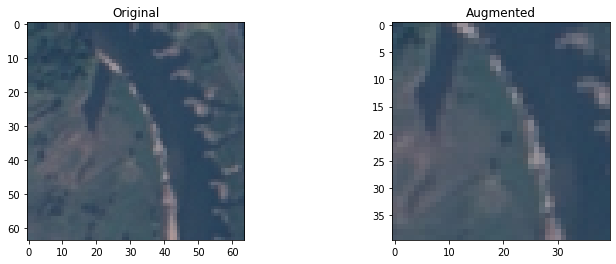

In [47]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6) # 이미지의 중심에서 일정 부분을 잘라냄
plot_augmentation(image, crop1)

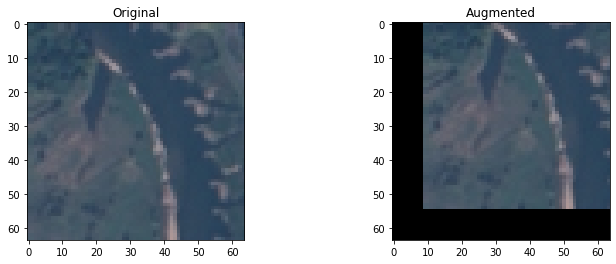

In [48]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3]) # 이미지를 원본 크기와 같게 자름
plot_augmentation(image, crop2)

> 원본 이미지가 상하좌우 랜덤한 방향으로 시프트 이동

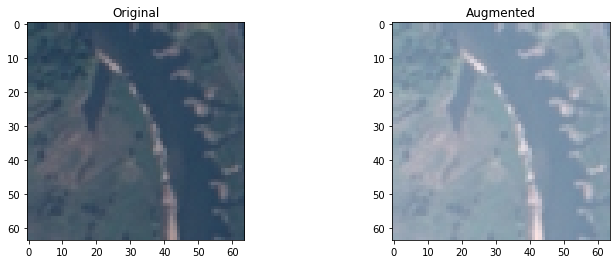

In [49]:
# 이미지 밝기 
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

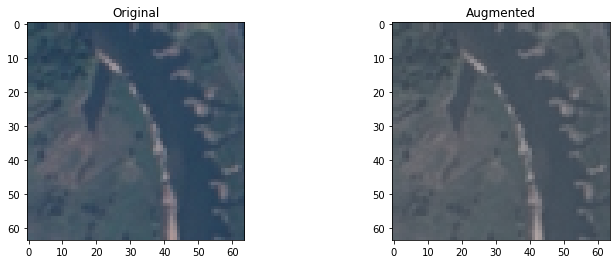

In [50]:
# 이미지 채도 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

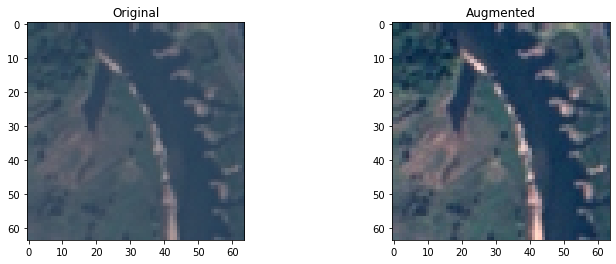

In [51]:
# 이미지 대비  
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

데이터 증강 및 전처리 수행

In [52]:
# 이미지 증강 전처리
def data_augmentation(image, label):
    # 이미지 증강 효과에 랜덤성을 부여하기 위해 tf.image 모듈에서 지원하는 함수 중 'random_'으로 시작하는 함수 적용
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

# map 함수로 원본 데이터셋에 적용
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle 함수와 batch 함수 등을 적용하여 미니 배치 생성
train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


모델 생성, 컴파일 및 훈련

In [53]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)   

Epoch 1/50
338/338 [==============================] - 16s 44ms/step - loss: 1.8504 - accuracy: 0.3197 - val_loss: 1.6632 - val_accuracy: 0.4148
Epoch 2/50
338/338 [==============================] - 10s 30ms/step - loss: 1.5564 - accuracy: 0.4128 - val_loss: 1.2781 - val_accuracy: 0.5591
Epoch 3/50
338/338 [==============================] - 10s 28ms/step - loss: 1.3898 - accuracy: 0.4774 - val_loss: 1.1937 - val_accuracy: 0.5878
Epoch 4/50
338/338 [==============================] - 11s 32ms/step - loss: 1.2903 - accuracy: 0.5189 - val_loss: 1.1454 - val_accuracy: 0.6259
Epoch 5/50
338/338 [==============================] - 15s 44ms/step - loss: 1.2378 - accuracy: 0.5438 - val_loss: 0.9962 - val_accuracy: 0.6613
Epoch 6/50
338/338 [==============================] - 10s 29ms/step - loss: 1.1435 - accuracy: 0.5886 - val_loss: 0.9217 - val_accuracy: 0.6844
Epoch 7/50
338/338 [==============================] - 10s 27ms/step - loss: 1.0964 - accuracy: 0.6050 - val_loss: 0.9143 - val_accuracy:

> 데이터 증강 전후 모델의 성능 자체는 큰 차이 없음

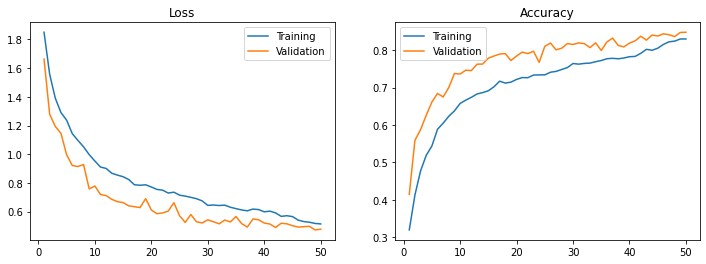

In [54]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(aug_history, 50)

> 훈련 셋과 검증 셋에 대한 손실함수는 50 epoch 동안 계속 감소
>
> 정확도는 조금씩 우상향하며 개선
>
> -> 과대적합 문제가 상당히 해소됨

#### 4-5 ResNet 사전 학습 모델

* ResNet 모델 : 이미지넷 경진 대회에서 우승한 모델, 152개의 깊은 층을 쌓는 방식으로 모델의 예측력을 높이면서도 skip connection 기법을 사용해 경사소실 문제 해결
* 전이 학습 이용 : 사전에 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델 구성

케라스에서 모델 인스턴스 불러오기

94683136/94668760 [==============================] - 1s 0us/step


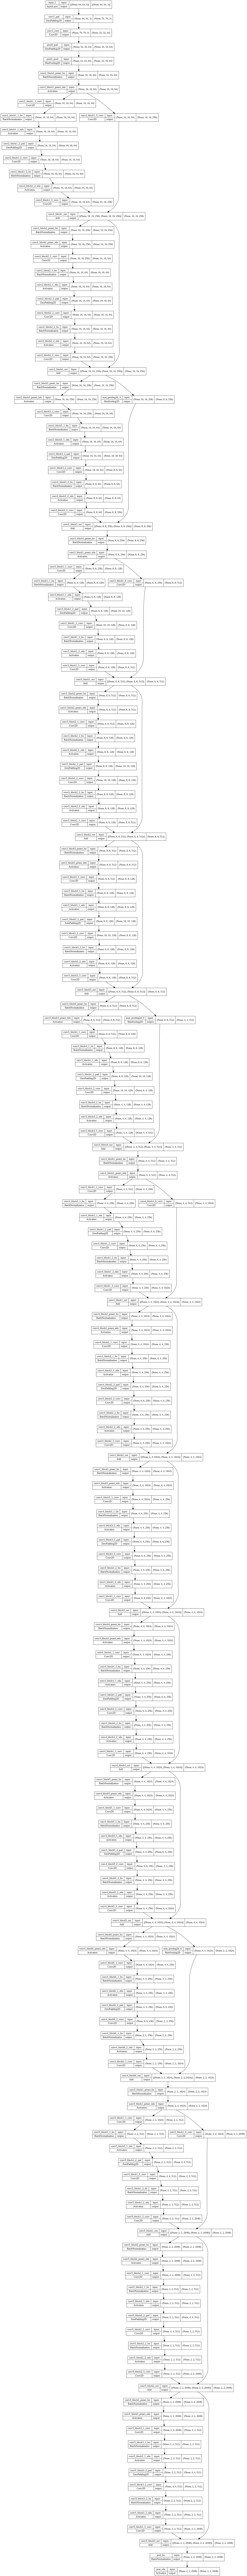

In [55]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, # 기존 ResNet 모델의 Top 층을 제거 -> 최종 분류기를 대체하여 추가
                              weights='imagenet',
                              input_shape=[64, 64, 3]) # 위성 이미지의 크기 지정 -> 케라스에서 이미지 크기를 지정한 크기로 맞춰서 줄여줌

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/ESAA/2022-1/과제/실습 필사/0620(월) 16주차 과제/resnet50.png')

In [56]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),     
        # 10개 클래스에 대한 다중 분류 -> Dense 레이어의 노드 개수 NUM_CLASSES와 softmax 활성화 함수 지정         
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'), # NUM_CLASSES : 위성 이미지의 클래스 레이블 개수(10)
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()    
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

> 23,564,800개의 파라미터는 훈련 불가능
>
> Top 층에 추가한 Dense 레이어들의 파라미터만 가중치가 업데이트됨

모델 컴파일 및 훈련

In [57]:
# 모델 컴파일
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# 모델 훈련
tc_history = tc_model.fit(train_aug, 
                          validation_data=valid_aug, 
                          epochs=50) 

Epoch 1/50
338/338 [==============================] - 25s 53ms/step - loss: 1.0282 - accuracy: 0.6727 - val_loss: 0.6048 - val_accuracy: 0.8037
Epoch 2/50
338/338 [==============================] - 14s 39ms/step - loss: 0.7224 - accuracy: 0.7649 - val_loss: 0.5442 - val_accuracy: 0.8144
Epoch 3/50
338/338 [==============================] - 16s 47ms/step - loss: 0.6378 - accuracy: 0.7951 - val_loss: 0.5096 - val_accuracy: 0.8296
Epoch 4/50
338/338 [==============================] - 14s 39ms/step - loss: 0.5999 - accuracy: 0.8065 - val_loss: 0.4876 - val_accuracy: 0.8346
Epoch 5/50
338/338 [==============================] - 12s 34ms/step - loss: 0.5668 - accuracy: 0.8158 - val_loss: 0.4661 - val_accuracy: 0.8431
Epoch 6/50
338/338 [==============================] - 12s 35ms/step - loss: 0.5470 - accuracy: 0.8225 - val_loss: 0.4632 - val_accuracy: 0.8481
Epoch 7/50
338/338 [==============================] - 12s 35ms/step - loss: 0.5148 - accuracy: 0.8325 - val_loss: 0.4619 - val_accuracy:

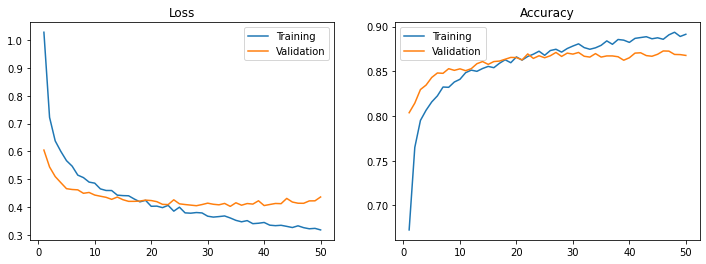

In [58]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(tc_history, 50)

> 훈련 초기부터 검증 셋에 대한 정확도가 80% 넘음
>  
>  -> 사전 학습 모델인 ResNet 모델의 가중치를 그대로 사용
>
> -> 새로운 데이터인 위성 이미지가 입력되어도 이미지로부터 피처를 빠르게 추출